# Downloading the data

The Quotebank data can be accessed from the following [link](https://drive.google.com/drive/folders/1R-GVIdxU3jkQb5zU0uG9044Vynh9nYR1?usp=sharing). You can create a shortcut in your Google Drive towards this folder by clicking on the name of folder (Quotebank) and choosing the option "*Add a shortcut to Drive*"
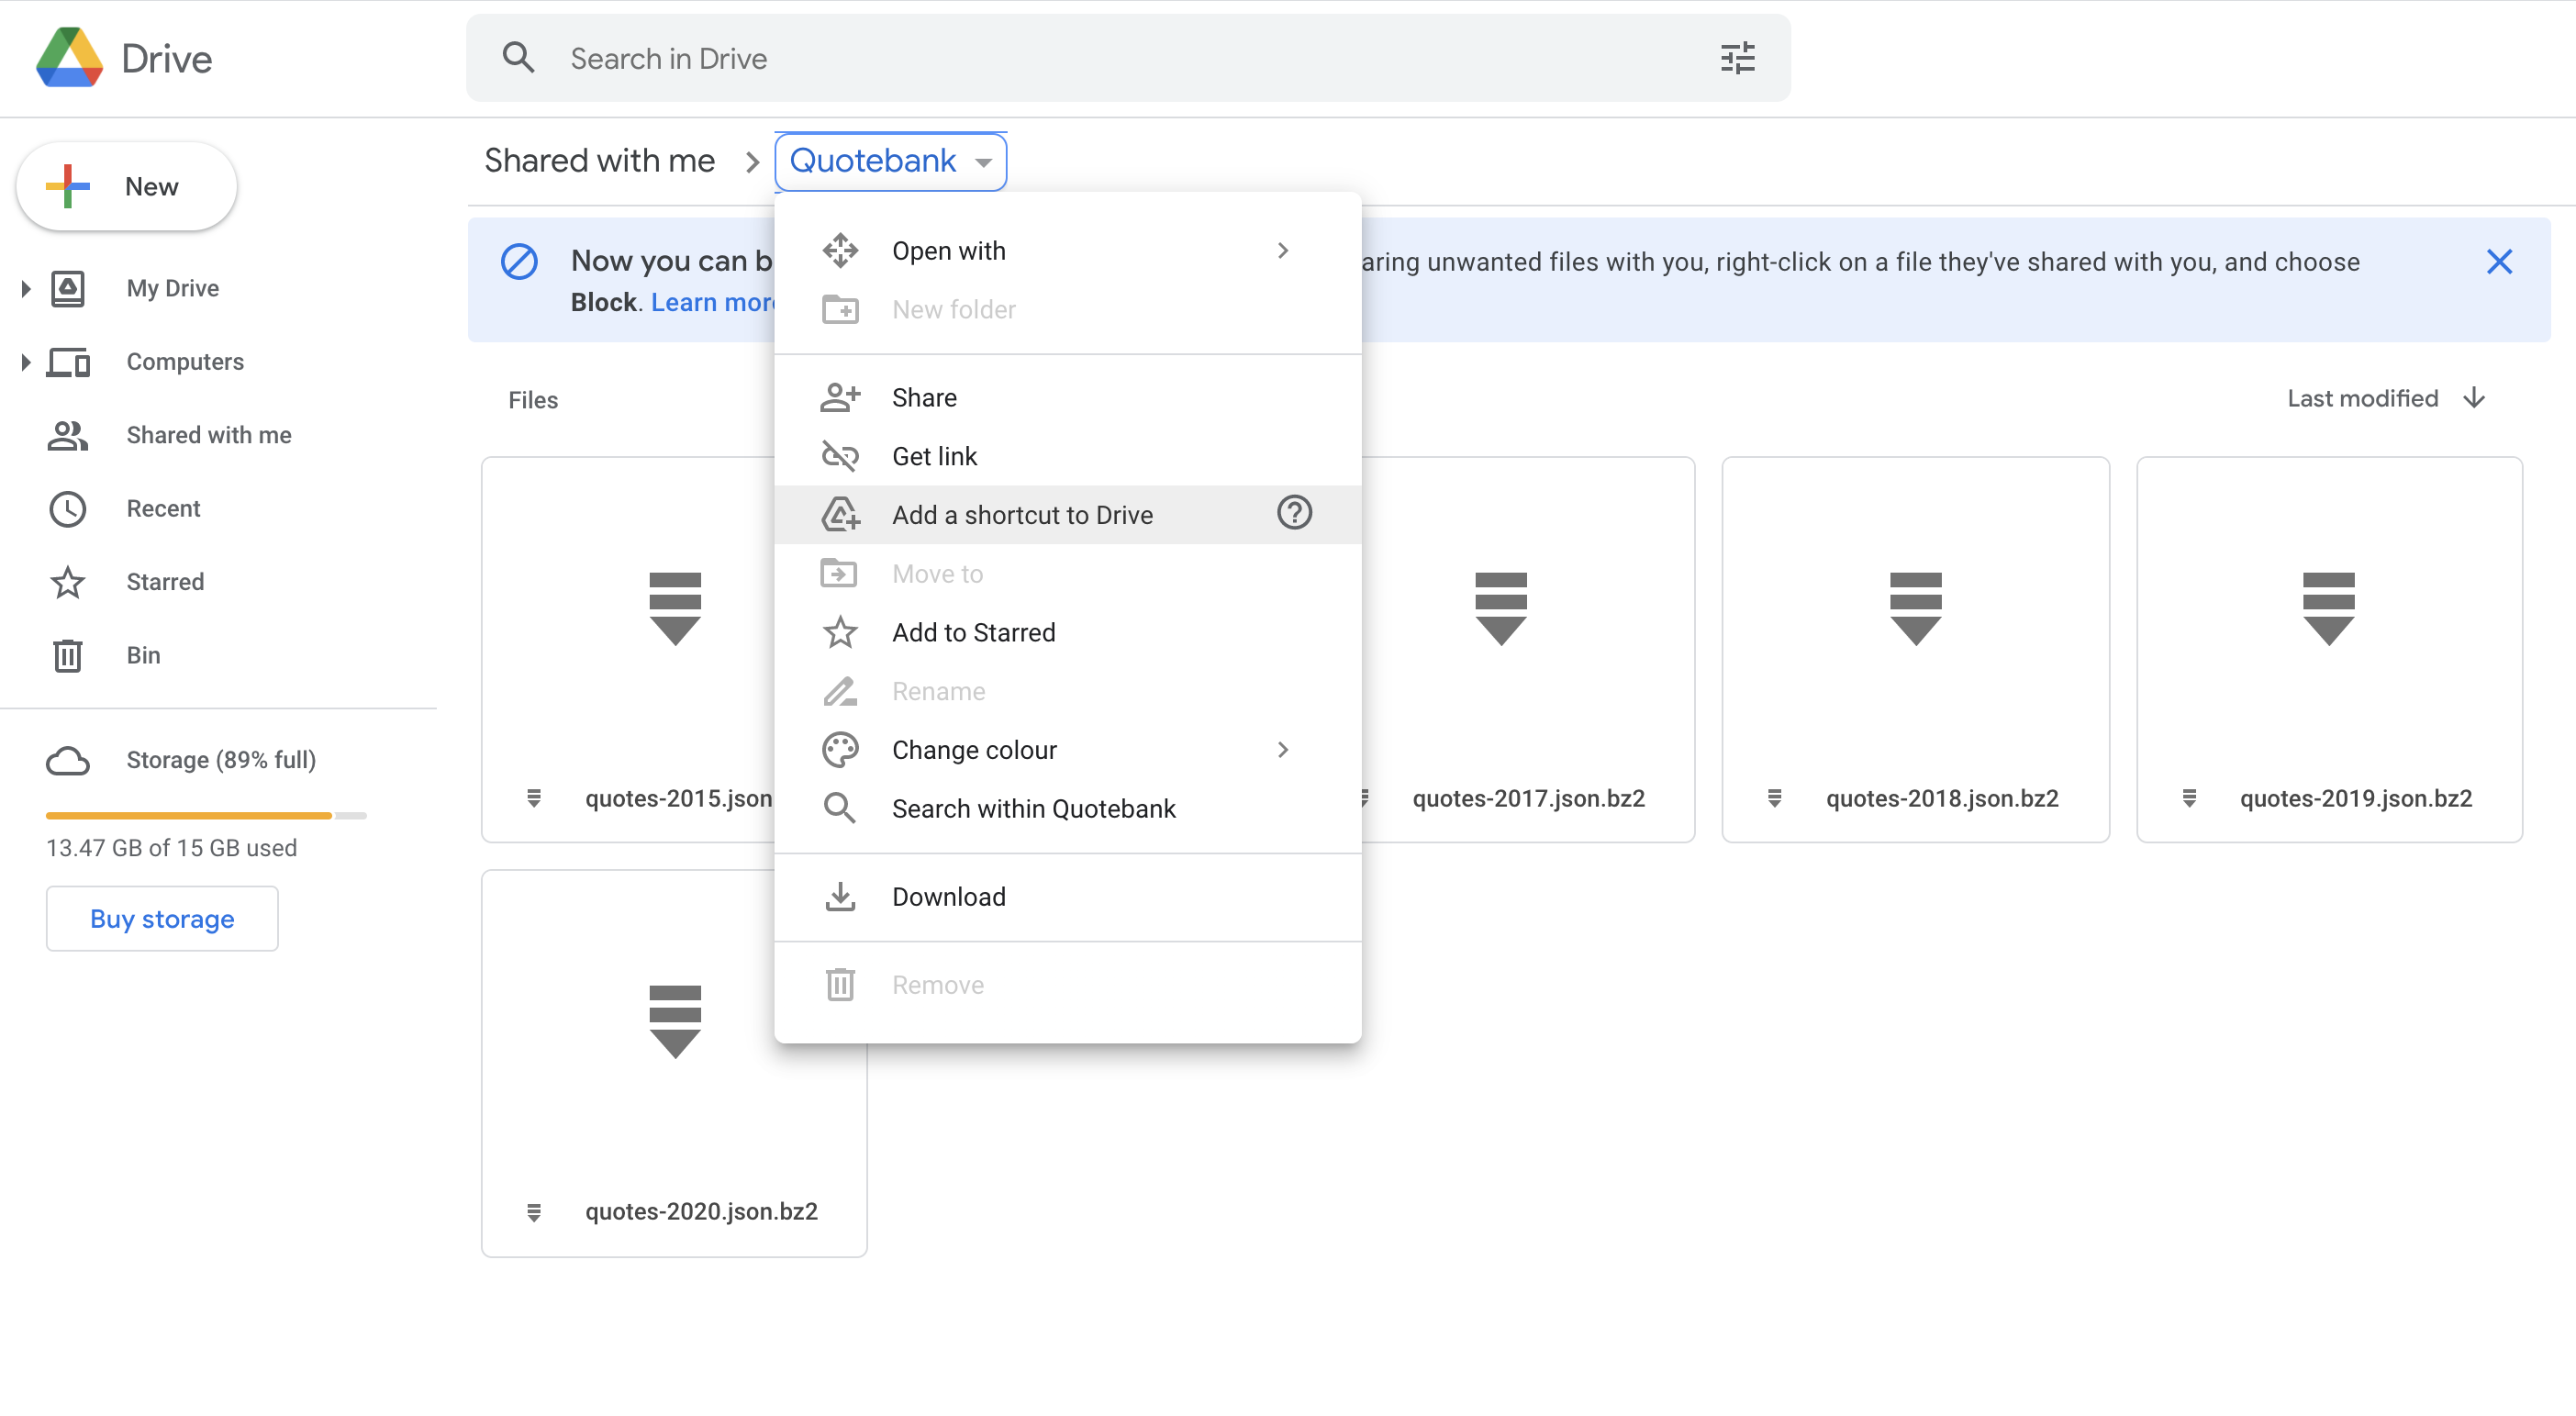

After that, click on ADD SHORTCUT button and the shortcut will be added to your drive. You will be able to access the shortcut from the root My Drive folder.

With your EPFL account you have access to a Google account with unlimited storage Google Drive. To log in, simply use your EPFL email address. This Google account cannot be used to run Colab notebooks but it is possible to run notebooks from one account while mounting a drive from the other one. You can use this drive to store your data (and add a shortcut to the Quotebank data).

# Mouting the Google Drive

It is possible to mount your Google Drive to Colab if you need additional storage or if you need to use files from it. To do that run (click on play button or use keyboard shortcut 'Command/Ctrl+Enter') the following code cell:

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


 

1.   After running the cell, URL will appear.

2.   Following this URL, you will be redirected to the page where you need to choose Google Drive account to mount to.

3.   You will further be asked to give Google Drive Stream a permission to access the chosen Google account

4.   After granting the access, authorization code will be given to you

5.   Copy the authorization code into the dedicated textbox in Colab under '*Enter your authorization code:*' writing

After copying the authorization code, you should get the message saying '*Mounted at /content/gdrive*'

Path to the files from the mounted Drive will then be '/content/drive/MyDrive/'. By opening the Files tab (left sidebar, folder icon) you should also be able to see the accessible files.

# Sample task

You can read the data directly from the Google Drive you mounted following the process above. Make sure you mounted the drive to which you saved the shortcut to the Quotebank data. We will go through a simple task with this data - we will extract domain names of URLs for each sample from the year 2020.

## Extracting the domain names

This is an example on how to extract domain names from a sample. To do that, we can use *tld* library. To install it:

In [2]:
# !pip install tld

     |████████████████████████████████| 412 kB 6.8 MB/s 


Following function then gives domain name. It takes as an argument an URL and returns the domain name:

In [3]:
# from tld import get_tld

# def get_domain(url):
#     res = get_tld(url, as_object=True)
#     return res.tld


Now we will have to read the data. Each sample has property 'urls' which contains a list of links to the original articles containing the quotation. We will extract domain names for these links. Then, we will save a new file that contains samples with extracted domains. The new file will be saved in local storage in Colab but you can change path_to_out variable (optionally) if you want to save it directly to the drive. To generate a new file, run this cell:

In [4]:
# import bz2
# import json

# path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 
# path_to_out = '/content/quotes-2020-domains.json.bz2'

# with bz2.open(path_to_file, 'rb') as s_file:
#     with bz2.open(path_to_out, 'wb') as d_file:
#         for instance in s_file:
#             instance = json.loads(instance) # loading a sample
#             urls = instance['urls'] # extracting list of links
#             domains = []
#             for url in urls:
#                 tld = get_domain(url)
#                 domains.append(tld)
#             instance['domains'] = domains # updating the sample with domain name
#             d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

KeyboardInterrupt: ignored

It should take around 25min for this cell to finish running and you will be able to see a file (*quotes-2020-domains.json.bz2*) in the file explorer on the left side once it is done.

You are all set, good luck! :)

## Installs

In [73]:
!pip install pytrends

## Imports

In [142]:
import bz2
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os.path
from pytrends.request import TrendReq
from google.colab import drive
from sklearn.preprocessing import StandardScaler

## Constants

In [11]:
# Whether to create a parsed file from the Quotebank dataset.
PARSE_QUOTEBANK = True

# Colorblind-friendly color palette.
COLORS = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']

# A mapping between a year and the file that contains the input of that year.
QUOTES_BY_YEAR = {year: f"/content/drive/MyDrive/politicians-quotes-{year}.json.bz2" for year in range(2015, 2021)}

## Setup

In [77]:
drive.mount('/content/drive')
pytrend = TrendReq()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Quote Parsing

In [19]:
# A list of politicians of interest.
politicians = ["Barack Obama", "George W. Bush", "Donald Trump", "John McCain",
            "Mitt Romney", "Hillary Clinton", "Benjamin Netanyahu",
            "Narendra Modi", "Joe Biden", "Theresa May", "Boris Johnson"]

In [46]:
def get_politicians_data(year):
  # Given a year, parses the Quotebank data and creates a file containing
  # the quotes of politicians from that year.
  path_to_out = QUOTES_BY_YEAR[year]
  with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
      for instance in s_file:
        # Load a sample.
        instance = json.loads(instance)
        if (sum([politician in instance['speaker'] for politician in politicians]) > 0):
          lines_written += 1
          # Write sample to new file.
          d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

In [47]:
# Store politicians data in DataFrame.
data = pd.read_json(QUOTES_BY_YEAR[2018], lines=True)

In [61]:
trump_quotes = data[data["speaker"].str.contains("Donald Trump")]
trump_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2018-05-08-001245,A constructive deal could easily have been str...,President Donald Trump,[Q22686],2018-05-08 18:36:49,8,"[[President Donald Trump, 0.5633], [None, 0.38...",[http://baynews9.com/fl/tampa/news/2018/05/08/...,E
1,2018-09-26-003692,actually admitted that they're going after far...,President Donald Trump,[Q22686],2018-09-26 00:00:00,138,"[[President Donald Trump, 0.6838], [None, 0.30...",[http://dailyherald.com/news/20180926/kavanaug...,E
3,2018-07-30-004176,always leaves room for negotiation.,President Donald Trump,[Q22686],2018-07-30 20:44:00,4,"[[President Donald Trump, 0.6616], [None, 0.33...",[http://www.10news.com/newsy/trump-25-billion-...,E
4,2018-10-30-005630,an incredible leader who is respected by every...,President Donald Trump,[Q22686],2018-10-30 03:10:00,3,"[[President Donald Trump, 0.358], [Cathy McMor...",[http://m.spokesman.com/stories/2018/oct/30/pr...,E
5,2018-04-21-003582,and he is already a proven liar and leaker.,President Donald Trump,[Q22686],2018-04-21 21:38:52,1,"[[President Donald Trump, 0.7394], [None, 0.16...",[https://mic.com/articles/189012/this-week-in-...,E


In [216]:
obama_quotes = data[data["speaker"].str.contains("Barack Obama")]
obama_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
21,2018-02-12-035226,I cannot paint.,Barack Obama,[Q76],2018-02-12 13:50:00,2,"[[Barack Obama, 0.8319], [Kehinde Wiley, 0.090...",[http://www.chicagotribune.com/news/ct-obama-p...,E
34,2018-11-03-029313,"incessant, non-stop attempts to divide us with...",Barack Obama,[Q76],2018-11-03 01:43:21,3,"[[Barack Obama, 0.7987], [None, 0.164], [Donal...",[http://thehill.com/homenews/news/414678-obama...,E
96,2018-10-22-004462,All right? I believe in a fact-based reality. ...,President Barack Obama,[Q76],2018-10-22 21:36:28,1,"[[President Barack Obama, 0.7669], [None, 0.21...",[http://www.rawstory.com/2018/10/dont-believe-...,E
156,2018-10-26-096425,The biggest threat to our democracy is cynicis...,President Barack Obama,[Q76],2018-10-26 19:37:30,3,"[[President Barack Obama, 0.8994], [None, 0.08...",[http://cbsnews.com/news/live-stream-obama-ral...,E
179,2018-11-14-125138,was the day I was getting my hair and makeup d...,Barack Obama,[Q76],2018-11-14 16:01:00,1,"[[Barack Obama, 0.7869], [None, 0.2131]]",[http://www.wmagazine.com/story/michelle-obama...,E


## Quotes and Google Trends

In [234]:
def plot_trend(all_quotes, keyword, year):
  # Get quotes stats from Quotebank.
  df_quotes = all_quotes[all_quotes["quotation"].str.contains(keyword)]
  df_quotes = df_quotes.groupby(by=df_quotes['date'].dt.date)
  quotes_occ = pd.DataFrame(df_quotes['numOccurrences'].sum(),
                           columns=['numOccurrences'])

  # Scale trend.
  quotes_occ["numOccurrences"] = StandardScaler().fit_transform(
    quotes_occ[["numOccurrences"]]
  )

  # Get Google Trends data.
  pytrend.build_payload(kw_list=[keyword], geo='US',
                        timeframe=f'{year}-01-01 {year}-12-31')
  df_google = pytrend.interest_over_time()

  # Scale trend.
  df_google[keyword] = StandardScaler().fit_transform(df_google[[keyword]])

  # Plot trends.
  fig, ax = plt.subplots(figsize=(10, 8))
  ax.plot(quotes_occ, label='Politician quote trend')
  df_google.plot(y=keyword, use_index=True, ax=ax, label='Google trend')
  
  ax.set_title(f'Quotes & Search Trend for "{keyword}"')
  ax.set_xlabel('Date')
  ax.set_ylabel('Trend')
  ax.legend()

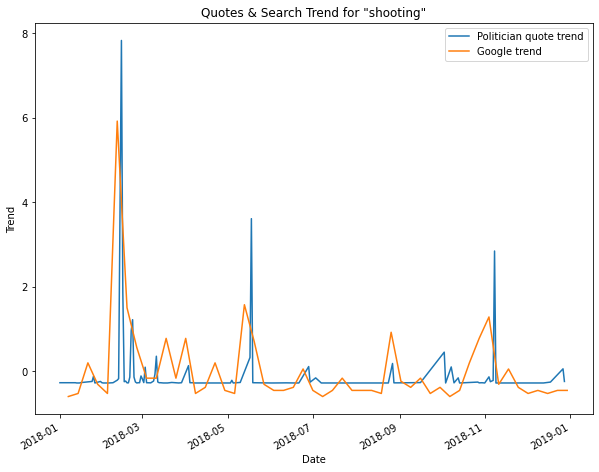

In [235]:
plot_trend(trump_quotes, 'shooting', 2018)

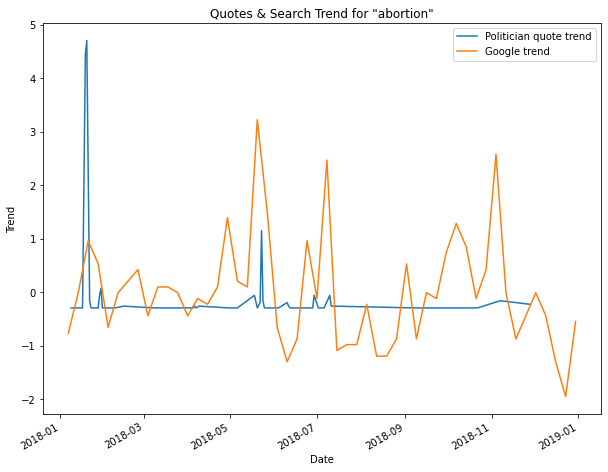

In [236]:
plot_trend(trump_quotes, 'abortion', 2018)

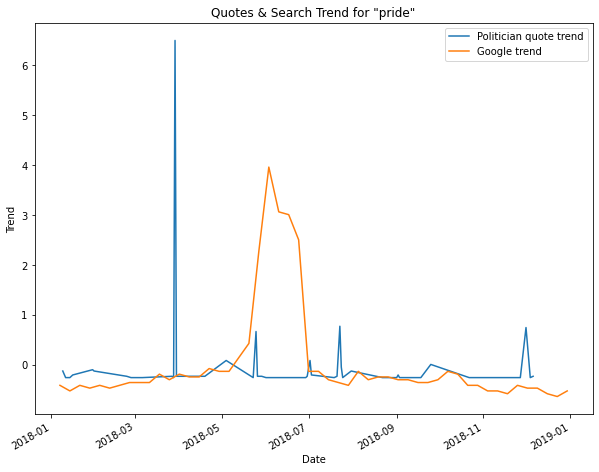

In [237]:
plot_trend(trump_quotes, 'pride', 2018)

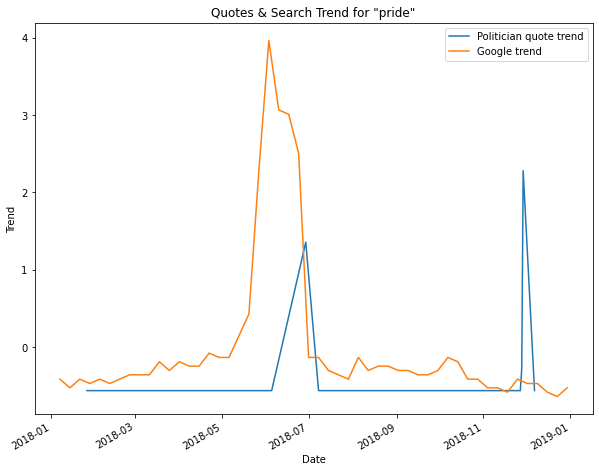

In [238]:
plot_trend(obama_quotes, 'pride', 2018)